In [1]:
import random
import torch
from typing import Tuple
import triton

import deep_gemm
from deep_gemm import bench_kineto, calc_diff, cell_div, get_col_major_tma_aligned_tensor
import transformer_engine.pytorch as te
from transformer_engine.common import recipe
import pandas as pd
from core import per_token_cast_to_fp8, per_block_cast_to_fp8, deep_matmul, DeepLinear
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from copy import deepcopy

In [2]:
def per_token_cast_to_fp82(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    assert x.dim() == 2 and x.size(1) % 128 == 0
    m, n = x.shape
    x_view = x.view(m, -1, 128)
    x_amax = x_view.abs().float().amax(dim=2).view(m, -1).clamp(1e-4)
    return (x_view * (448.0 / x_amax.unsqueeze(2))).to(torch.float8_e4m3fn).view(m, n), (x_amax / 448.0).view(m, -1)


def per_block_cast_to_fp82(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    assert x.dim() == 2
    m, n = x.shape
    x_padded = torch.zeros((cell_div(m, 128) * 128, cell_div(n, 128) * 128), dtype=x.dtype, device=x.device)
    x_padded[:m, :n] = x
    x_view = x_padded.view(-1, 128, x_padded.size(1) // 128, 128)
    x_amax = x_view.abs().float().amax(dim=(1, 3), keepdim=True).clamp(1e-4)
    x_scaled = (x_view * (448.0 / x_amax)).to(torch.float8_e4m3fn)
    return x_scaled.view_as(x_padded)[:m, :n].contiguous(), (x_amax / 448.0).view(x_view.size(0), x_view.size(2))


def construct(x, y):
    m = x.size(0)
    n = y.size(0)
    out = torch.empty((m, n), device='cuda', dtype=torch.bfloat16)

    x_fp8, y_fp8 = per_token_cast_to_fp82(x), per_block_cast_to_fp82(y)
    # Transpose earlier so that the testing will not trigger transposing kernels
    x_fp8 = (x_fp8[0], get_col_major_tma_aligned_tensor(x_fp8[1]))
    return x_fp8, y_fp8, out

# def construct_grouped(list_x, list_y):
#     list_x_fp8 = []
#     list_y_fp8 = []
#     list_out = []
#     for idx in range(len(list_x)):

def construct_grouped(x, y, is_masked=False) -> \
        Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor], torch.Tensor, torch.Tensor]:
    num_groups, m,k = x.shape
    n = y.size(1)
    out = torch.empty((num_groups, m, n), device='cuda', dtype=torch.bfloat16)

    assert m % 4 == 0, f'TMA alignment error: {m}'
    x_fp8 = (torch.empty_like(x, dtype=torch.float8_e4m3fn), torch.empty((num_groups, m, k // 128), device='cuda', dtype=torch.float))
    y_fp8 = (torch.empty_like(y, dtype=torch.float8_e4m3fn), torch.empty((num_groups, (n + 127) // 128, k // 128), device='cuda', dtype=torch.float))
    for i in range(num_groups):
        x_fp8[0][i], x_fp8[1][i] = per_token_cast_to_fp8(x[i])
        y_fp8[0][i], y_fp8[1][i] = per_block_cast_to_fp8(y[i])

    # For non-masked input, we must merge the group and M dims
    if not is_masked:
        x_fp8 = (x_fp8[0].view(-1, k), per_token_cast_to_fp8(x.view(-1, k))[1])
        out = out.view(-1, n)

    # Transpose earlier so that the testing will not trigger transposing kernels
    x_fp8 = (x_fp8[0], get_col_major_tma_aligned_tensor(x_fp8[1]))
    return x_fp8, y_fp8, out



def deep_matmul2(x, y):
    x_fp8, y_fp8, out = construct(x, y)
    deep_gemm.gemm_fp8_fp8_bf16_nt(x_fp8, y_fp8, out)
    return out

def group_deep_matmul(x, y):
    num_groups, m, k = x.shape
    x_fp8, y_fp8, out = construct_grouped(x, y)
    m_indices = torch.arange(0, num_groups, device='cuda', dtype=torch.int)
    m_indices = m_indices.unsqueeze(-1).expand(num_groups, m).contiguous().view(-1)
    deep_gemm.m_grouped_gemm_fp8_fp8_bf16_nt_contiguous(x_fp8, y_fp8, out, m_indices)
    return out

fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
def te_matmul(x, fc):
    with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
        out = fc(x)
    return out

def group_te_matmul(x, fc, num_groups):
    splits = [x.size(0)//num_groups] * num_groups
    with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
        out = fc(x, splits)
    return out

In [3]:
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 4095, 4096*2, 4096*2
x = torch.randn(m, n, dtype=dtype, device=device)
fc = torch.nn.Linear(k, n, bias=False, device=device, dtype=dtype)
y = fc.weight
x_fp8, y_fp8, out = construct(x, y)
out_ref = fc(x)

In [12]:
a_fp8 = per_token_cast_to_fp8(x)
b_fp8 = per_block_cast_to_fp8(y)

In [ ]:
out1 = deep_matmul2(x, y)
out2 = deep_matmul(x, y)

AssertionError: 

In [9]:
print((out1 - out_ref).abs().max(), (out1 - out_ref).abs().mean())
print((out2 - out_ref).abs().max(), (out2 - out_ref).abs().mean())

tensor(0.1133, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0167, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.1133, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0167, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)


In [10]:
print(triton.testing.do_bench(lambda:deep_matmul2(x, y)))
print(triton.testing.do_bench(lambda:deep_matmul(x, y)))
print(triton.testing.do_bench(lambda:fc(x)))

1.8756002187728882
0.574105441570282
0.7976258993148804


In [5]:
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 4096*2, 4096*4, 4096
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
bias = False
fc1 = torch.nn.Linear(k, n, bias=bias, device=device, dtype=dtype)
fc2 = DeepLinear(k, n, bias=bias, device=device, dtype=dtype)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)

In [6]:
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
print((fc1.weight.grad - fc2.weight.grad).abs().max(), (fc1.weight.grad - fc2.weight.grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(0.1328, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0167, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.1406, device='cuda:0', dtype=torch.bfloat16) tensor(0.0190, device='cuda:0', dtype=torch.bfloat16)
tensor(11., device='cuda:0', dtype=torch.bfloat16) tensor(1.5312, device='cuda:0', dtype=torch.bfloat16)


In [7]:
print(triton.testing.do_bench(lambda:fc1(x1)))
print(triton.testing.do_bench(lambda:fc2(x2)))
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.rand_like(y1)
print(triton.testing.do_bench(lambda:y1.backward(dy, retain_graph=True), grad_to_none=[x1, fc1.weight]))
print(triton.testing.do_bench(lambda:y2.backward(dy, retain_graph=True), grad_to_none=[x2, fc2.weight]))

1.5591166019439697
1.143518328666687
3.2884576320648193
2.541518211364746


# Test TE

In [1]:
from transformer_engine.pytorch.module.deep_linear import Linear as TeLinear
from transformer_engine.pytorch.module.deep_layernorm_linear import LayerNormLinear as TeLayerNormLinear
from transformer_engine.pytorch.module.deep_group_linear import GroupedLinear as TeGroupLinear

import transformer_engine.pytorch as te
from transformer_engine.common import recipe
import torch
from copy import deepcopy
import triton
from core import deep_group_matmul, deep_matmul
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
def fp8_run(linear, *args):
    with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
        out = linear(*args)
    return out

## Linear

In [2]:

# with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 1024, 4096*4, 4096
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
bias = False
fc1 = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
fc2 = TeLinear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
fc1.weight.main_grad = torch.zeros_like(fc1.weight.data, dtype=torch.float32)
fc2.weight.main_grad = torch.zeros_like(fc1.weight.data, dtype=torch.float32)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)
dy = torch.randn(m, n, device=device, dtype=dtype)


In [3]:
with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    print(fc1.fp8)
    out = fc1(x1)
    print(fc1.fp8)

False
True


In [3]:
y1 = fc1(x1)
y2 = fp8_run(fc2, x2)
# y2 = fc2(x2)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
print((fc1.weight.main_grad - fc2.weight.main_grad).abs().max(), (fc1.weight.main_grad - fc2.weight.main_grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(0.3281, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0432, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.5625, device='cuda:0', dtype=torch.bfloat16) tensor(0.0864, device='cuda:0', dtype=torch.bfloat16)
tensor(6.7666, device='cuda:0') tensor(0.9414, device='cuda:0')


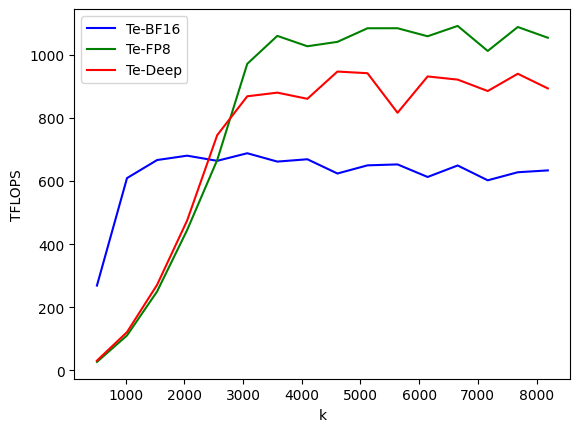

forward:
         k     Te-BF16       Te-FP8     Te-Deep
0    512.0  268.652431    26.605852   30.733985
1   1024.0  609.326692   110.533930  121.080653
2   1536.0  666.556533   249.831088  270.850784
3   2048.0  680.409005   444.627310  474.847535
4   2560.0  664.096829   666.459989  745.347798
5   3072.0  688.118262   971.548875  868.628767
6   3584.0  661.668784  1060.133752  880.241950
7   4096.0  669.028545  1027.261830  860.664483
8   4608.0  623.905483  1041.197561  947.073395
9   5120.0  649.722412  1084.306502  941.807514
10  5632.0  652.703269  1084.388442  816.420694
11  6144.0  612.866522  1058.921837  931.547267
12  6656.0  649.309013  1091.716248  921.497583
13  7168.0  602.312188  1012.380671  885.334528
14  7680.0  627.871471  1088.266152  940.062916
15  8192.0  633.702288  1054.227976  893.572134


In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 4096, 'bias': False},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    perf = lambda ms: 2 * m  * n * k * 1e-12 / (ms * 1e-3)
    if provider == 'Te-BF16':
        fc = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fc(x))
    if provider == 'Te-FP8':
        fc = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x))
    if provider == 'Te-Deep':
        fc = TeLinear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x))
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

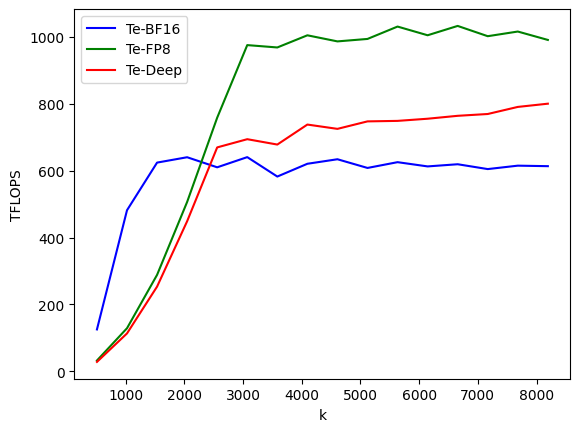

forward + backward:
         k     Te-BF16       Te-FP8     Te-Deep
0    512.0  125.489512    32.696117   28.454032
1   1024.0  481.476243   129.095083  113.609846
2   1536.0  623.729016   288.420285  253.358489
3   2048.0  639.767211   506.200058  448.591967
4   2560.0  609.684699   757.897278  669.128315
5   3072.0  640.084802   974.637310  693.645414
6   3584.0  582.078483   967.618661  677.636859
7   4096.0  620.239422  1003.914492  737.351454
8   4608.0  633.757202   985.730900  724.493093
9   5120.0  607.782730   993.061486  746.845948
10  5632.0  625.027399  1030.014885  748.328325
11  6144.0  612.352550  1004.045440  754.777641
12  6656.0  618.831079  1031.942975  763.482513
13  7168.0  604.386742  1001.251161  768.883923
14  7680.0  614.607671  1015.178945  790.033587
15  8192.0  613.071654   990.107062  799.695386


In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 4096, 'bias': False},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    dy = torch.randn(m, n, dtype=dtype, device=device)
    def fwd_bwd(fc, x, dy, fp8=False):
        if fp8:
            y = fp8_run(fc, x)
        else:
            y = fc(x)
        y.backward(dy)
    perf = lambda ms: 6  * m  * n * k * 1e-12 / (ms * 1e-3)
    if provider == 'Te-BF16':
        fc = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy), grad_to_none=[x])
    if provider == 'Te-FP8':
        fc = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, fp8=True), grad_to_none=[x])
    if provider == 'Te-Deep':
        fc = TeLinear(k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, fp8=True), grad_to_none=[x])
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

## NormLinear

In [23]:
fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 256, 512, 1024
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
bias = False
fc1 = te.LayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
fc2 = TeLayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
fc2.layer_norm_weight.data.copy_(fc1.layer_norm_weight.data)
fc1.weight.main_grad = torch.zeros_like(fc1.weight.data, dtype=torch.float32)
fc2.weight.main_grad = torch.zeros_like(fc1.weight.data, dtype=torch.float32)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)
dy = torch.randn(m, n, device=device, dtype=dtype)

In [24]:
y1 = fc1(x1)
y2 = fp8_run(fc2, x2)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
print((fc1.weight.main_grad - fc2.weight.main_grad).abs().max(), (fc1.weight.main_grad - fc2.weight.main_grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(0.1406, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0216, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0928, device='cuda:0', dtype=torch.bfloat16) tensor(0.0153, device='cuda:0', dtype=torch.bfloat16)
tensor(3.0956, device='cuda:0') tensor(0.4709, device='cuda:0')


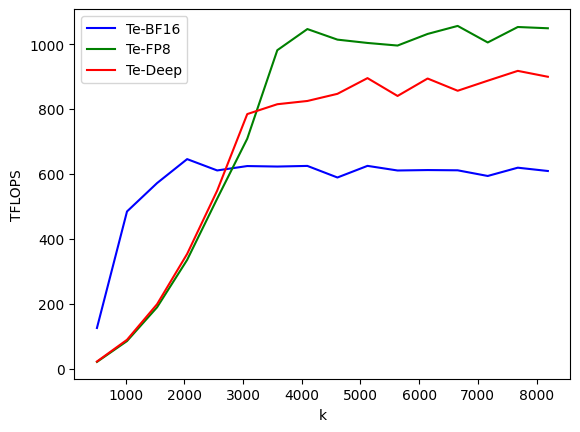

forward:
         k     Te-BF16       Te-FP8     Te-Deep
0    512.0  125.694680    21.123649   22.371109
1   1024.0  484.597841    85.390707   89.317871
2   1536.0  572.005718   189.415229  198.955779
3   2048.0  645.834068   335.383493  353.763575
4   2560.0  610.929647   524.149958  548.870357
5   3072.0  624.454936   708.754651  784.566135
6   3584.0  622.950011   981.342194  814.913579
7   4096.0  624.891737  1046.453376  824.927607
8   4608.0  589.215627  1013.883218  846.928405
9   5120.0  625.041801  1003.655037  895.318414
10  5632.0  610.789077   995.676048  840.375739
11  6144.0  612.133585  1031.421537  894.093544
12  6656.0  611.369502  1056.108569  856.403213
13  7168.0  593.911122  1005.162888  887.379075
14  7680.0  619.415624  1052.781867  917.664706
15  8192.0  609.230861  1048.905481  899.507347


In [25]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 4096, 'bias': False},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    perf = lambda ms: 2 * m  * n * k * 1e-12 / (ms * 1e-3)
    if provider == 'Te-BF16':
        fc = te.LayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fc(x))
    if provider == 'Te-FP8':
        fc = te.LayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x))
    if provider == 'Te-Deep':
        fc = TeLayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x))
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

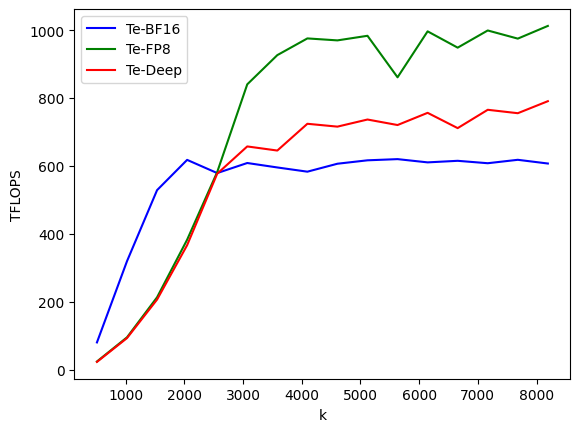

forward + backward:
         k     Te-BF16       Te-FP8     Te-Deep
0    512.0   80.316746    24.150979   22.888217
1   1024.0  319.642319    95.390658   93.109807
2   1536.0  528.863758   213.275529  206.565885
3   2048.0  617.990099   382.877419  366.750029
4   2560.0  579.148806   582.036068  577.201479
5   3072.0  608.766741   840.490239  657.601244
6   3584.0  595.676381   926.545733  645.487991
7   4096.0  583.247321   975.761100  724.319920
8   4608.0  606.660565   969.959142  715.912492
9   5120.0  616.716450   983.484131  736.870505
10  5632.0  620.204151   861.208770  720.632400
11  6144.0  610.640710   996.568410  756.570555
12  6656.0  615.249208   948.557042  711.531768
13  7168.0  608.137728   999.163815  765.543773
14  7680.0  618.221283   975.151428  755.467762
15  8192.0  607.276972  1012.558754  790.861354


In [26]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 4096, 'bias': False},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m, k, dtype=dtype, device=device)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    dy = torch.randn(m, n, dtype=dtype, device=device)
    def fwd_bwd(fc, x, dy, fp8=False):
        if fp8:
            y = fp8_run(fc, x)
        else:
            y = fc(x)
        y.backward(dy)
    perf = lambda ms: 6  * m  * n * k * 1e-12 / (ms * 1e-3)
    if provider == 'Te-BF16':
        fc = te.LayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy), grad_to_none=[x])
    if provider == 'Te-FP8':
        fc = te.LayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, fp8=True), grad_to_none=[x])
    if provider == 'Te-Deep':
        fc = TeLayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        fc.weight.main_grad = torch.zeros(n, k, dtype=torch.float32, device=device)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, fp8=True), grad_to_none=[x])
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

## GroupLinear

In [30]:

# with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
device = 'cuda'
dtype = torch.bfloat16
n, k = 4096*4, 4096

bias = False
num_groups = 4
fc1 = te.GroupedLinear(num_groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
fc2 = TeGroupLinear(num_groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
for idx in range(num_groups):
    weight_1 = getattr(fc1, f'weight{idx}')
    weight_2 = getattr(fc2, f'weight{idx}')
    weight_1.main_grad = torch.zeros_like(weight_1.data, dtype=torch.float32)
    weight_2.main_grad = torch.zeros_like(weight_2.data, dtype=torch.float32)
    weight_2.data.copy_(weight_1.data)
m_sllits = torch.randint(1024, 2048, (num_groups, )).tolist()

x1 = torch.randn(sum(m_sllits), k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
dy = torch.randn(sum(m_sllits), n, device=device, dtype=dtype)

In [34]:
y1 = fc1(x1, m_sllits)
y2 = fp8_run(fc2, x2, m_sllits)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
for idx in range(num_groups):
    weight_1 = getattr(fc1, f'weight{idx}')
    weight_2 = getattr(fc2, f'weight{idx}')
    print((weight_1.main_grad - weight_2.main_grad).abs().max(), (weight_1.main_grad - weight_2.main_grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(11.6250, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0762, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(87., device='cuda:0', dtype=torch.bfloat16) tensor(0.6133, device='cuda:0', dtype=torch.bfloat16)
tensor(32.3311, device='cuda:0') tensor(4.5430, device='cuda:0')
tensor(39.0451, device='cuda:0') tensor(5.1563, device='cuda:0')
tensor(31.4139, device='cuda:0') tensor(4.5982, device='cuda:0')
tensor(34.6432, device='cuda:0') tensor(4.2758, device='cuda:0')


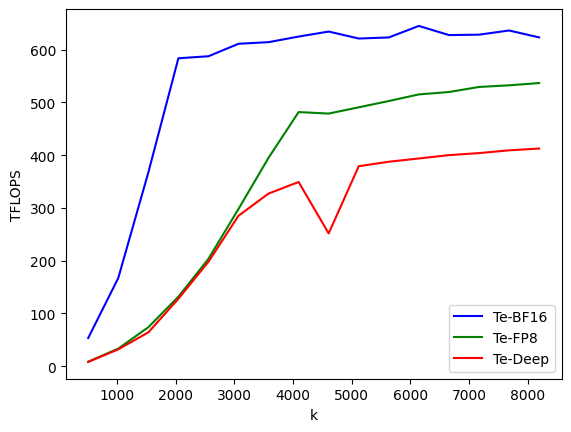

forward:
         k     Te-BF16      Te-FP8     Te-Deep
0    512.0   53.290006    8.403882    7.998123
1   1024.0  167.011275   33.221042   31.869169
2   1536.0  367.099917   73.779577   64.022500
3   2048.0  583.660607  131.595805  127.741789
4   2560.0  587.515778  203.452960  197.831311
5   3072.0  611.179410  298.027226  285.167832
6   3584.0  614.249962  395.013308  327.179416
7   4096.0  624.800048  481.664133  349.128725
8   4608.0  634.345793  478.841421  251.589763
9   5120.0  621.108142  490.716253  379.074285
10  5632.0  623.185179  502.635046  387.530052
11  6144.0  645.014066  515.193587  393.725490
12  6656.0  627.682367  519.698373  400.032028
13  7168.0  628.426381  529.272541  403.884453
14  7680.0  636.332378  532.439156  409.123992
15  8192.0  623.237660  536.690260  412.558929


In [ ]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 512, 'bias': False, 'groups': 8},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, groups, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m*groups, k, dtype=dtype, device=device)
    m_splits = [m] * groups
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    perf = lambda ms: 2 * groups * m * n * k * 1e-12 / (ms * 1e-3)
    if provider == 'Te-BF16':
        fc = te.GroupedLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fc(x, m_splits))
    if provider == 'Te-FP8':
        fc = te.GroupedLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x, m_splits))
    if provider == 'Te-Deep':
        fc = TeGroupLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        ms = triton.testing.do_bench(lambda: fp8_run(fc, x, m_splits))
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

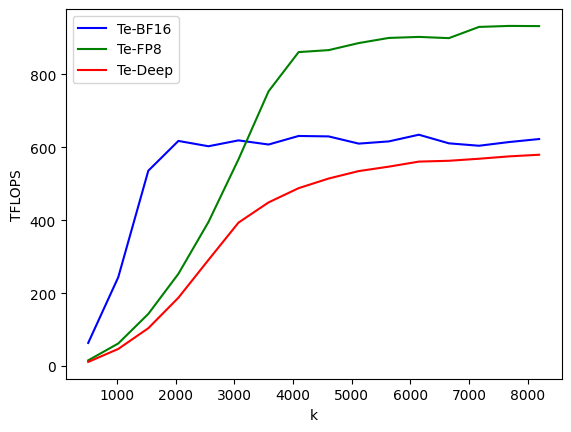

forward:
         k     Te-BF16      Te-FP8     Te-Deep
0    512.0   63.285464   15.489815   11.246931
1   1024.0  243.649262   61.849769   46.851918
2   1536.0  535.858478  143.008125  103.768758
3   2048.0  617.555191  252.905912  187.316287
4   2560.0  602.957705  394.969419  291.045680
5   3072.0  619.055730  567.167234  393.490558
6   3584.0  607.693939  753.706842  448.906247
7   4096.0  631.174653  861.270807  487.967587
8   4608.0  629.951030  866.715090  514.413976
9   5120.0  610.193485  886.056139  534.854969
10  5632.0  616.260753  900.132422  546.988174
11  6144.0  634.593359  902.933471  560.839947
12  6656.0  610.948008  899.569027  563.112077
13  7168.0  604.346673  930.335282  568.701650
14  7680.0  614.488032  933.088990  575.173128
15  8192.0  622.759888  932.614428  579.677431


In [19]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['k'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Te-BF16', 'Te-FP8', 'Te-Deep'],  # possible values for `line_arg``
        line_names=[
            "Te-BF16",
            "Te-FP8",
            'Te-Deep'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 2048, 'bias': False, 'groups': 2},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(m, k, bias, groups, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    n = 4 * k
    x = torch.randn(m*groups, k, dtype=dtype, device=device)
    m_splits = [m] * groups
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    dy = torch.randn(sum(m_splits), n, dtype=dtype, device=device)
    def fwd_bwd(fc, x, dy, *args, fp8=False):
        if fp8:
            y = fp8_run(fc, x, *args)
        else:
            y = fc(x, *args)
        y.backward(dy)
    perf = lambda ms: 6  *  groups * m  * n * k * 1e-12 / (ms * 1e-3)

    if provider == 'Te-BF16':
        fc = te.GroupedLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        for idx in range(groups):
            weight = getattr(fc, f'weight{idx}')
            weight.main_grad = torch.zeros_like(weight.data, dtype=torch.float32)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, m_splits), grad_to_none=[x])
    if provider == 'Te-FP8':
        fc = te.GroupedLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        for idx in range(groups):
            weight = getattr(fc, f'weight{idx}')
            weight.main_grad = torch.zeros_like(weight.data, dtype=torch.float32)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, m_splits, fp8=True), grad_to_none=[x])
    if provider == 'Te-Deep':
        fc = TeGroupLinear(groups, k, n, bias=bias, device=device, params_dtype=dtype, fuse_wgrad_accumulation=True)
        for idx in range(groups):
            weight = getattr(fc, f'weight{idx}')
            weight.main_grad = torch.zeros_like(weight.data, dtype=torch.float32)
        ms = triton.testing.do_bench(lambda: fwd_bwd(fc, x, dy, m_splits, fp8=True), grad_to_none=[x])
    return perf(ms)
benchmark.run(show_plots=True, print_data=True)

In [13]:
fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
# with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 256, 512, 1024
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
bias = False
fc1 = TeLinear(k, n, bias=bias, device=device, params_dtype=dtype)
fc2 = TeLinear(k, n, bias=bias, device=device, params_dtype=dtype)
# fc2 = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)

In [14]:
y1 = fc1(x1)
with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    y2 = fc2(x2)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
print((fc1.weight.grad - fc2.weight.grad).abs().max(), (fc1.weight.grad - fc2.weight.grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(0.1328, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0217, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0508, device='cuda:0', dtype=torch.bfloat16) tensor(0.0087, device='cuda:0', dtype=torch.bfloat16)
tensor(1.6406, device='cuda:0', dtype=torch.bfloat16) tensor(0.2637, device='cuda:0', dtype=torch.bfloat16)


In [8]:
fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
device = 'cuda'
dtype = torch.bfloat16
m, n, k = 256, 512, 1024
x1 = torch.randn(m, k, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
bias = False
fc1 = TeLayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype)
fc2 = TeLayerNormLinear(k, n, normalization='RMSNorm', bias=bias, device=device, params_dtype=dtype)
# fc2 = te.Linear(k, n, bias=bias, device=device, params_dtype=dtype)
fc2.weight.data.copy_(fc1.weight.data)
fc2.layer_norm_weight.data.copy_(fc1.layer_norm_weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)

In [9]:
y1 = fc1(x1)
with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    y2 = fc2(x2)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1 - y2).abs().max(), (y1 - y2).abs().mean())
print((x1.grad - x2.grad).abs().max(), (x1.grad - x2.grad).abs().mean())
print((fc1.weight.grad - fc2.weight.grad).abs().max(), (fc1.weight.grad - fc2.weight.grad).abs().mean())
print((fc1.layer_norm_weight.grad - fc2.layer_norm_weight.grad).abs().max(), (fc1.layer_norm_weight.grad - fc2.layer_norm_weight.grad).abs().mean())
if bias:
    print((fc1.bias.grad - fc2.bias.grad).abs().max(), (fc1.bias.grad - fc2.bias.grad).abs().mean())

tensor(0.1250, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0215, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0488, device='cuda:0', dtype=torch.bfloat16) tensor(0.0088, device='cuda:0', dtype=torch.bfloat16)
tensor(1.6562, device='cuda:0', dtype=torch.bfloat16) tensor(0.2676, device='cuda:0', dtype=torch.bfloat16)
tensor(0.8750, device='cuda:0', dtype=torch.bfloat16) tensor(0.1328, device='cuda:0', dtype=torch.bfloat16)


In [12]:
torch.__version__

'2.5.1+cu124'